# Yolo v3 en Keras parte 3

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
! cp /content/drive/MyDrive/clases/"Computer Vision Modulo 1"/"Clase 8"/yolov3.h5 ./yolov3.h5

In [9]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf

In [10]:
yolov3 = load_model('./yolov3.h5')

## Bounding Boxs

In [51]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
    self.xmin = xmin
    self.xmax = xmax
    self.ymax = ymax
    self.ymin = ymin
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label_score(self):
    self.label = np.argmax(self.classes)
    self.score = self.classes[self.label]
    return self.label, self.score

def decode_anchors(netout_o, anchors, net_h, net_w, obj_thresh):
  netout = netout_o.copy()
  boxes = []
  grid_h, grid_w = netout.shape[:2]
  n_box = 3
  filters_out = (5+80)
  netout = netout.reshape((grid_h, grid_w, n_box,-1))
  netout[...,:2] = tf.sigmoid(netout[...,:2]).numpy()
  netout[...,4:] = tf.sigmoid(netout[...,4:]).numpy()
  netout[...,5:] = netout[...,4][...,np.newaxis]*netout[...,5:]# Tenemos las probabilidades de cada clase
  netout[...,5:] *= netout[...,5:] > obj_thresh # Aplicamos umbral
  for i in range(grid_h):
    for k in range(grid_w):
      for b in range(n_box):
        objectness = netout[i][k][b][4]
        if(objectness <= obj_thresh): continue
        tx, ty, tw, th = netout[i][k][b][:4]
        x = (tx + k) / grid_w
        y = (ty + i) / grid_h
        w = anchors[2*b + 0] * np.exp(tw) / net_w
        h = anchors[2*b + 1] * np.exp(th) / net_h
        classes = netout[i][k][b][5:]
        box = BoundBox(x-w/2,y-h/2,x+w/2,y+h/2, objectness, classes)
        box.get_label_score()
        boxes.append(box)
  return boxes

Prueba 1, sobre una imagen

In [12]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

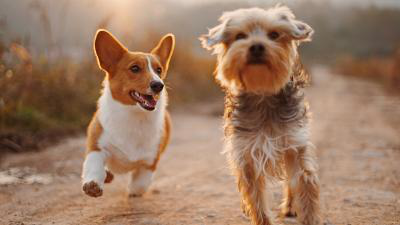

In [14]:
img = load_img('dogs.jpg')
img

In [15]:
img = np.array(img)
wh_img = img.shape

In [16]:
wh_img

(225, 400, 3)

In [42]:
img = load_img('dogs2.jpg',target_size=(416,416))
img = np.array(img)*1./255 - 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


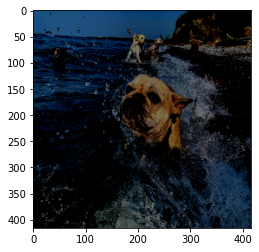

In [43]:
plt.imshow(img)
plt.show()

In [44]:
netout = yolov3.predict(img.reshape((-1,416,416,3)))

In [45]:
netout[0].shape

(1, 13, 13, 255)

In [46]:
netout[2][0][5][5][:25]

array([  0.6616554 ,  -1.4621943 ,  -0.19598037,  -0.51637423,
        -9.480894  ,  -6.13363   ,  -8.211353  , -10.400306  ,
        -9.922729  ,  -9.552913  , -14.095432  , -12.165837  ,
       -12.124057  ,  -6.80746   , -10.701359  , -11.910817  ,
       -12.055727  , -11.555782  ,  -9.256422  ,   5.3687367 ,
        -9.079793  ,  -7.822184  ,  -8.795624  ,  -8.954935  ,
        -8.997521  ], dtype=float32)

In [22]:
anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23]]
thresh_class = 0.6
BOXES = []
for k in range(3):
  NETOUT = netout[k][0]
  boxes = decode_anchors(NETOUT, anchors[k], 416, 416, thresh_class)
  try:
    BOXES.extend(boxes)
  except:
    continue

0.93924594 0.8002535 4.0861635 -7.6286607
0.5064022 0.75522 2.6721816 -7.0387807
0.3225578 0.5829484 0.66587853 -1.8557
0.5281289 0.72594106 1.1898733 -1.9223764
0.8199449 0.09525168 -1.0343121 -2.69207
0.63419706 0.008985519 5.0568542 -5.6155715
0.95325494 0.032743454 0.8866539 -2.284061
0.93391645 0.051237315 1.043895 -3.6912804
0.7823039 0.02185136 0.9359494 -7.5879164
0.37265304 0.12466696 1.3247838 -4.097343
0.99508613 0.0544807 1.9480507 -2.3656447
0.9932462 0.9238299 5.9708486 -0.4784437
0.92474556 0.15817368 5.6979923 -2.8611689
0.5538873 0.041500926 0.44587907 -0.72191757
0.9948389 0.026986718 1.5332813 -2.0299885
0.49527645 0.112342864 0.15230134 -1.8844609
0.99988675 0.29544938 7.493739 -2.3839586
0.9452938 0.23901263 5.810404 -3.0043204
0.81732374 0.73278356 4.8751445 -5.0071774
0.5950591 0.17532301 3.751192 -3.109903
0.99971986 0.13321179 1.6638696 -1.2225337
0.8962642 0.4815871 2.8984199 -0.13017353
0.9987092 0.23037049 6.0758467 -2.041233
0.30785832 0.046737432 4.7167196

In [23]:
boxs = [x for x in BOXES if np.argmax(x.classes)!=0]
boxs

In [24]:
BOXES[70].xmin, BOXES[70].xmax, BOXES[70].ymin, BOXES[70].ymax

(-0.43828679965092576,
 2.091764046595647,
 0.19500263215293392,
 0.19674003288114014)

## Corregir Bounding Box

In [25]:
def correct_boxes(boxes, img_h, img_w, net_h, net_w):
  new_w, new_h = net_w, net_h
  for i in range(len(boxes)):
    x_off, x_scale = (net_w - new_w)/2./net_w, float(new_w/net_w)
    y_off, y_scale = (net_h - new_h)/2./net_h, float(new_h/net_h)
    boxes[i].xmin = int((boxes[i].xmin - x_off) / x_scale * img_w)
    boxes[i].xmax = int((boxes[i].xmax - x_off) / x_scale * img_w)
    boxes[i].ymin = int((boxes[i].ymin - y_off) / y_scale * img_h)
    boxes[i].ymax = int((boxes[i].ymax - y_off) / y_scale * img_h)

In [26]:
correct_boxes(boxs, 720, 1280, 416, 416)

In [27]:
BOXES[70].xmin, BOXES[70].xmax, BOXES[70].ymin, BOXES[70].ymax

(-561, 2677, 140, 141)

## Graficar Box

In [28]:
def iou(box1, box2):
  int_x = max(box1.xmin, box2.xmin) -  min(box1.xmax, box2.xmax)
  int_y = max(box1.ymin, box2.ymin) -  min(box1.ymax, box2.ymax)
  ixy = int_x*int_y
  uxy = 1 + (box1.xmax-box1.xmin)*(box1.ymax-box1.ymin) + (box2.xmax-box2.xmin)*(box2.ymax-box2.ymin)
  uxy = uxy - ixy
  return ixy/uxy

In [29]:
def nms(boxes, nms_thresh):
  if len(boxes) > 0:
    n_class = len(boxes[0].classes)
  else:
    return
  for c in range(n_class):
    sorted_idx = np.argsort([-box.classes[c] for box in boxes])
    for i in range(len(sorted_idx)):
      idx_i = sorted_idx[i]
      if boxes[idx_i ].classes[c] == 0: continue
      for j in range(i+1, len(sorted_idx)):
        idx_j = sorted_idx[j]
        if iou(boxes[idx_i], boxes[idx_j])>= nms_thresh:
          boxes[idx_j].classes[c] = 0

In [30]:
def get_boxes(boxes, labels, thresh):
  boxes_out, labels_out, scores_out = [], [], []
  for box in boxes:
    for i in range(len(labels)):
      if box.classes[i] > thresh:
        boxes_out.append(box)
        labels_out.append(labels[i])
        scores_out.append(box.classes[i])
  return boxes_out, labels_out, scores_out

In [59]:
from matplotlib.patches import Rectangle
def plot_box(path, boxes_out, labels_out, scores_out):
  img = plt.imread(path)
  img_h, img_w, _ = img.shape
  plt.imshow(img)
  ax = plt.gca()
  for i in range(len(boxes_out)):
    box = boxes_out[i]
    x1,x2,y1,y2 = box.xmin, box.xmax, box.ymin, box.ymax
    w,h = x2-x1, y2-y1
    if w>img_w or h>img_h: continue
    # Graficamos
    r = Rectangle((x1,y1), w, h, fill=False, color='blue', linewidth='1.2')
    ax.add_patch(r)
    # Texto
    label = '{}: {:.2f}'.format(labels_out[i], scores_out[i])
    plt.text(x1,y1, label, color='blue')
plt.show()

## Implementacion final de Yolo

In [77]:
anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23]]
thresh_class = 0.4

In [78]:
labels = []
with open('names.txt','r') as file:
  for line in file:
    labels.append(line.strip())

In [79]:
def yolo_detect(path):
  img = load_img(path)
  nimg = np.array(img)
  img_h, img_w, _ = nimg.shape
  img =  img.resize((416,416))
  img = np.array(img)*1./255 - 0.5
  predict = yolov3.predict(img.reshape(1,416,416,3))
  boxes = []
  for i in range(len(predict)):
    boxes += decode_anchors(predict[i][0],anchors[i],416,416,thresh_class)
  correct_boxes(boxes, img_h, img_w, 416, 416)
  nms(boxes, 0.5)
  boxes_out, labels_out, scores_out = get_boxes(boxes, labels, thresh_class)
  for i in range(len(boxes_out)):
    print(labels_out[i], scores_out[i])
  
  plot_box(path, boxes_out, labels_out, scores_out)

dog 0.99584734
dog 0.9714236


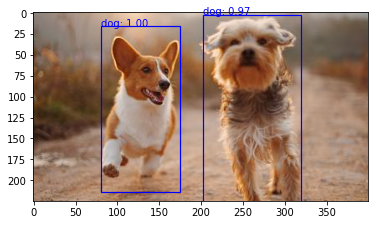

In [80]:
yolo_detect('/content/dogs.jpg')

person 0.63055724


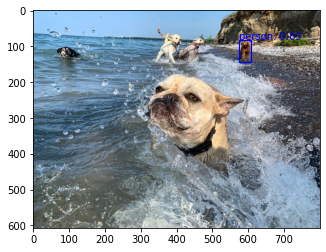

In [81]:
yolo_detect('/content/dogs2.jpg')

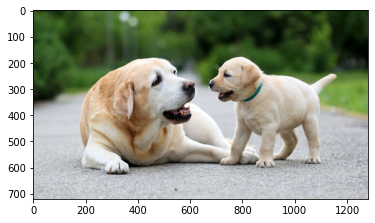

In [82]:
yolo_detect('/content/dogs3.jpg')

bear 0.7829634


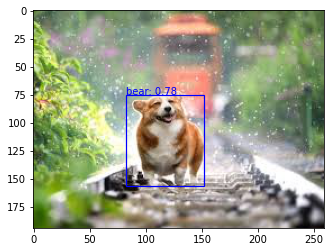

In [83]:
yolo_detect('/content/mini_dog.jpg')

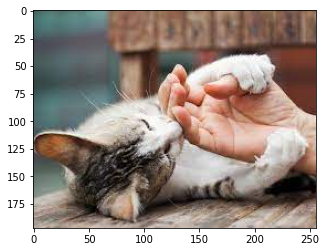

In [84]:
yolo_detect('/content/cat.jpg')

person 0.9712272
car 0.4439443
truck 0.7498495
dog 0.9606992
car 0.9854796
car 0.97662497
car 0.6048904
car 0.93358123


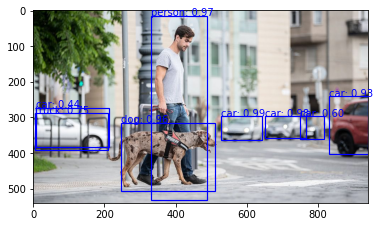

In [85]:
yolo_detect('/content/3804_DSC9769.jpg')